In [1]:
import os
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException

os.environ.pop('HTTP_PROXY', None)
os.environ.pop('HTTPS_PROXY', None)
os.environ.pop('http_proxy', None)
os.environ.pop('https_proxy', None)



# Directory to save the downloaded files
download_dir = "/home/disk1/finance_quant/efinance/downloaded_files"
os.makedirs(download_dir, exist_ok=True)

# Initialize ChromeDriver
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Enable logging
options.set_capability('goog:loggingPrefs', {'performance': 'ALL'})

driver = webdriver.Chrome(options=options)

# Enable network interception
driver.execute_cdp_cmd('Network.enable', {})




{}

In [3]:
import logging

def capture_and_clear_logs(driver, log_type='performance'):
  """
  Captures logs of the specified type from the WebDriver and then clears them.

  Args:
      driver (webdriver.Chrome): The WebDriver instance.
      log_type (str, optional): The type of logs to capture (e.g., 'performance', 'browser'). Defaults to 'performance'.

  Returns:
      list: The captured logs as a list of dictionaries, where each dictionary represents a log entry.
  """

  # Configure dummy logger (adjust as needed)
  logger = logging.getLogger(__name__)
  handler = logging.NullHandler()  # Avoid console output
  logger.addHandler(handler)

  # Attach the logger to the WebDriver (if applicable)
  driver.logger = logger

  # Capture logs
  logs = driver.get_log(log_type)

  # Clear captured logs from the handler (example with NullHandler)
  for handler in logger.handlers:
      if isinstance(handler, logging.NullHandler):
          pass  # No need to clear for NullHandler

  return logs

def click(driver, element):
    driver.execute_script("arguments[0].scrollIntoView();", element)
    driver.execute_script("arguments[0].click();", element)

In [4]:
import json
import pandas as pd
from typing import List, Dict, Tuple

def parse_json(json_data: str) -> List[Dict]:
    """Parse JSON data and extract stock items."""
    data = json.loads(json_data)
    return [item['stock'] for item in data['data']['items']]

def categorize_stocks(stocks: List[Dict]) -> Dict[str, List[Dict]]:
    """Categorize stocks by market."""
    categorized = {}
    for stock in stocks:
        market = stock['market']
        if market not in categorized:
            categorized[market] = []
        categorized[market].append(stock)
    return categorized

def save_to_csv(stocks: List[Dict], filename: str) -> None:
    """Save stocks to a CSV file."""
    if stocks:
        df = pd.DataFrame(stocks)
        df.to_csv(filename, index=False)
        print(f"Stocks saved to {filename}")

def process_multiple_stock_data(json_data_list: List[str]) -> Dict[str, List[Dict]]:
    """Process multiple JSON data strings and return categorized stocks."""
    all_stocks = []
    for json_data in json_data_list:
        all_stocks.extend(parse_json(json_data))
    
    categorized_stocks = categorize_stocks(all_stocks)
    
    for market, stocks in categorized_stocks.items():
        file_path = os.path.join(download_dir, f"{market.lower()}_stocks.csv")
        save_to_csv(stocks, file_path)
    
    return categorized_stocks

driver.get_page

Found element with class tab and text United States
Found element with class tab and text Sector
log: {'method': 'Network.responseReceived', 'params': {'frameId': '7384A0BA3B4B59A34C9639CD6F037766', 'hasExtraInfo': True, 'loaderId': '9972A25F44DE98A457B34CFC99D469AB', 'requestId': '1968818.617', 'response': {'alternateProtocolUsage': 'unspecifiedReason', 'charset': '', 'connectionId': 223, 'connectionReused': True, 'encodedDataLength': 648, 'fromDiskCache': False, 'fromPrefetchCache': False, 'fromServiceWorker': False, 'headers': {'access-control-allow-credentials': 'true', 'access-control-allow-origin': 'https://longportapp.cn', 'access-control-expose-headers': 'X-Trace-Id,Account-Channel,Org-Id,X-Stage,App-Id,X-Ip,X-Authorization,X-Now', 'content-encoding': 'gzip', 'content-security-policy': "default-src 'self'; script-src 'self' 'unsafe-inline' 'unsafe-eval' https://cdn.jsdelivr.net; img-src 'self' https://cdn.jsdelivr.net; style-src 'self' 'unsafe-inline' https://cdn.jsdelivr.net; 
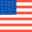
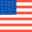

In [7]:

# Function to save downloaded file (if applicable)
def save_file(url, content):
    filename = os.path.join(download_dir, url.split('/')[-1])
    with open(filename, 'wb') as f:
        f.write(content.encode('utf-8'))
    print(f"Downloaded {filename}")
    
def save_json(content):
  filename = os.path.join(download_dir, "data.json")
  with open(filename, "w") as outfile:
    json.dump(content, filename)

# Function to process performance logs
def process_browser_logs_for_network_events(logs):
    for entry in logs:
        log = json.loads(entry['message'])['message']
        if (
            'Network.responseReceived' in log['method']
            and 'params' in log
            and 'response' in log['params']
        ):
            response = log['params']['response']
            url = response['url']
            if any(url.endswith(ext) for ext in ['.js', '.css', '.json', '.svg']):
                try:
                    content = driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': log['params']['requestId']})
                    save_file(url, content['body'])
                except Exception as e:
                    print(f"Error getting response body for {url}: {e}")
                    
# Function to process performance logs
def process_browser_logs_for_network_events_json(logs):
    target_url = "https://api.lbkrs.com/market/concept_stocks"
    

    all_jsons = []
    for entry in logs:
        log = json.loads(entry['message'])['message']
        if (
            'Network.responseReceived' in log['method']
            and 'params' in log
            and 'response' in log['params']
        ):
            response = log['params']['response']
            url = response['url']
            if url.startswith(target_url):
                try:
                    print(f"log: {log}")
                    content = driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': log['params']['requestId']})
                    # save_json(json.loads(content['body']))
                    print(f"content: {content['body']}")
                    all_jsons.append(content['body'])
                    # return True  # Found and saved the target URL
                except Exception as e:
                    print(f"Error getting response body for {url}: {e}")
    
    return all_jsons  # Target URL not found

def find_element_by_class_and_text(driver, class_name, main_page_text, sub_page_text=None):
    """
    This function finds an element with a specific class name and text content.

    Args:
        driver: The WebDriver instance.
        class_name: The class name of the element to search for.
        main_page_text: The primary text content to search for.
        sub_page_text (optional): An additional text content to search for (defaults to None).

    Returns:
        The WebElement if found, otherwise None.
    """
    main_element = None
    sub_element = None
    
    try:
        elements = driver.find_elements(By.CLASS_NAME, class_name)
        for element in elements:
            if element.text == main_page_text:
                print(f"Found element with class {class_name} and text {main_page_text}")
                WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, class_name)))
                try:
                    element.click()
                except ElementClickInterceptedException:
                    click(driver, element)
                main_element = element
                break  # Exit after finding and clicking the main text
        
        if sub_page_text:
            elements = driver.find_elements(By.CLASS_NAME, class_name)
            for element in elements:
                if element.text == sub_page_text:
                    print(f"Found element with class {class_name} and text {sub_page_text}")
                    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, class_name)))
                    try:
                        element.click()
                    except ElementClickInterceptedException:
                        click(driver, element)
                    sub_element = element
                    break  # Exit after finding and clicking the sub text (if provided)
    
    except TimeoutException:
        print(f"Timeout waiting for element with class {class_name}")
    
    if main_element and (sub_page_text is None or sub_element):
        return main_element, sub_element
    else:
        print(f"Element with class {class_name}, main_page_text '{main_page_text}', sub_page_text '{sub_page_text}' not found")
        return None

# Example usage:
# driver = webdriver.Chrome()
# driver.get("https://example.com")
# find_element_by_class_and_text(driver, "example-class", "Main Page Text", "Sub Page Text")
# driver.quit()


# ... (rest of your code)

try:

    # Open a webpage
    driver.get("https://longportapp.com/en/markets/")

    # Wait for page to load (adjust wait time and selector as needed)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "portal")))
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "tabs")))
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "tab")))
    # WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "United States")))
    # WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "Sector")))

    # XPath expression to target the child element with the symbol

    # find_element_by_class_and_text(driver, "tab", "Hong Kong",  "Sector")


    # Retrieve and process performance logs
    # logs = driver.get_log('performance')
    
    # logs = capture_and_clear_logs(driver, 'performance')
    # process_browser_logs_for_network_events_json(logs)

    find_element_by_class_and_text(driver, "tab", "United States", "Sector")
    logs = driver.get_log('performance')
    # logs = capture_and_clear_logs(driver, 'performance')
    all_jsons = process_browser_logs_for_network_events_json(logs)

    if len(all_jsons) > 0:
      process_multiple_stock_data(all_jsons)


finally:
    print(logs)
    
#     # Quit the driver
#     driver.quit()


In [15]:
driver.quit()